# Starbucks Promotion Analysis

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. **You'll want to try to assess what a certain demographic group will buy when not receiving any offers.**

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example

(1) You could build a machine learning model that predicts how much someone will spend based on demographics and offer type.  
  
(2) You could build a model that predicts whether or not someone will respond to an offer.   
  
(3) You could develop a set of heuristics that determine what offer you should send to each customer. (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

# Analysis Overview 

1. Load in files
2. Clean the data
3. Univariate Exploration

# 1. Load in files

In [22]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 2. Clean the data

## (1)Portfile

In [23]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


## (2)Profile

In [24]:
# copy the dataframes
profile2 = profile.copy()

In [25]:
print(profile2.shape)
profile2.head()

(17000, 5)


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [26]:
# replace 118 in age column with nan
profile2.age = profile.age.replace(118, np.nan)

# convert "became_member_on" column to datetime type
profile2.became_member_on = pd.to_datetime(profile2.became_member_on, format="%Y%m%d")

# one_hot_encode "gender" column
profile2 = profile2.join(pd.get_dummies(profile2.gender,prefix="gender",dummy_na=True))
profile2 = profile2.drop("gender", axis = 1)

In [27]:
# replace values in "gender_F","gender_M","gender_O" clumns with nan if the gender is not unclear
for i, if_nan in enumerate(profile2.gender_nan):
    if if_nan == 1:
        profile2.loc[i, "gender_F"] = np.nan
        profile2.loc[i, "gender_M"] = np.nan
        profile2.loc[i, "gender_O"] = np.nan
profile2 = profile2.drop("gender_nan", 1)

In [28]:
profile2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
age                 14825 non-null float64
became_member_on    17000 non-null datetime64[ns]
id                  17000 non-null object
income              14825 non-null float64
gender_F            14825 non-null float64
gender_M            14825 non-null float64
gender_O            14825 non-null float64
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 929.8+ KB


In [29]:
# the numbere of customers whose ALL of age, income, gender are missed. 
print((profile2.isnull().sum(axis=1) == 5).sum())

2175


## (3) Transcript

In [37]:
transcript2 = transcript.copy()

In [38]:
# remove "offer_id", "offer id", "amount" and strip each cell value (since they are clear.)

spl_list = []

for each_value in transcript2.value:
    try :
        v = str(each_value).split(": ")[1]
        #print(v)
        if v[0].isdigit():
            v = v[:-1]
            
        elif v[0] == "'":
            v = v.split("'")[1]
    except Exception as e:
        print(e, v)

    spl_list.append(v)

transcript2.value = spl_list

In [39]:
# divide the column "value" into 2 columns which are "id" (for offer_received,offer_viewed,offer_completed)
#                                                    and "reward"  (for transaction)

l_reward = []
l_offer = []

for each_value in transcript2.value:
    try:
        each_value = float(each_value)
        l_reward.append(each_value)
        l_offer.append(np.nan)
    except:
        l_reward.append(np.nan)
        l_offer.append(each_value)

transcript2["reward"] = l_reward
transcript2["id"] = l_offer
transcript2 = transcript2.drop("value", axis=1)

transcript2.head()

,event,person,time,reward,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [85]:
transcript2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 5 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
reward    138953 non-null float64
id        167581 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 11.7+ MB


# Univariate Exploration
## (1) profile

In [61]:
profile2.describe()

,age,income,gender_F,gender_M,gender_O
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300
std,17.383705,21598.299410,0.492464,0.494765,0.118729
min,18.000000,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000


<Figure size 432x288 with 0 Axes>

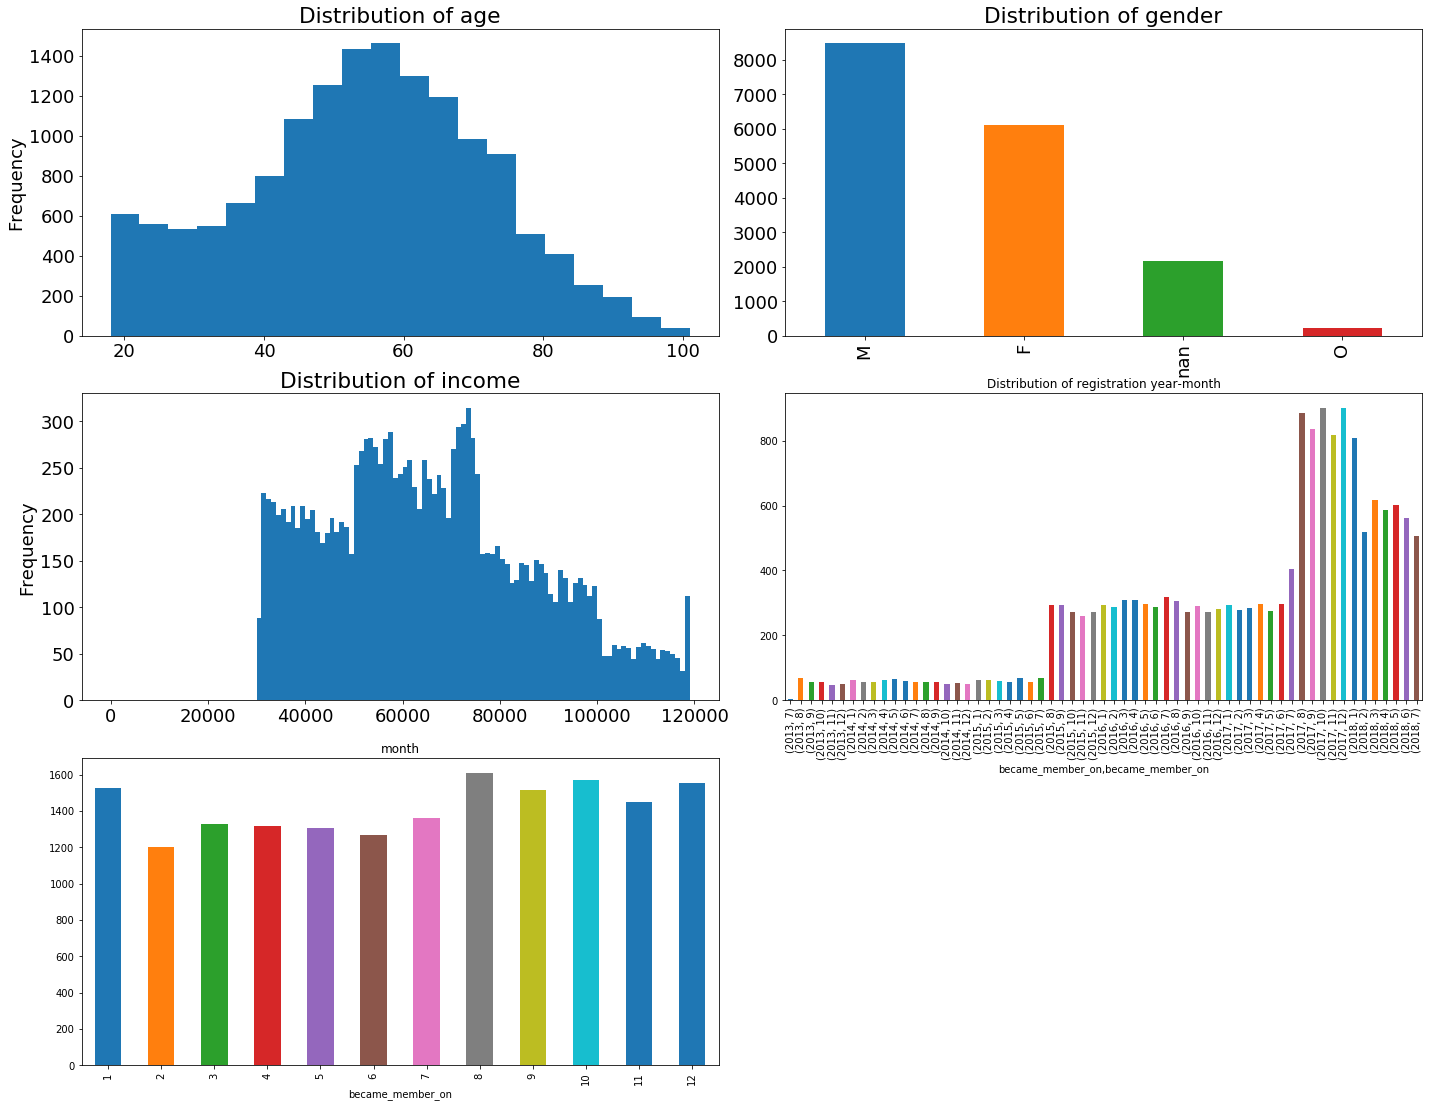

In [62]:
plt.rcParams["font.size"] = 18
plt.tight_layout()

plt.figure(figsize=[20,15])
plt.subplot(3,2,1)
plt.title("Distribution of age")
profile2.age.plot("hist", bins=20)
plt.subplot(3,2,2)
plt.title("Distribution of gender")
profile.gender.value_counts(dropna=False).plot(kind="bar")
plt.subplot(3,2,3)
plt.title("Distribution of income")
profile.income.plot("hist", bins=np.arange(0,profile2.income.max(),1000))

plt.rcParams["font.size"] = 10
plt.tight_layout()
plt.subplot(3,2,4)
plt.title("Distribution of registration year-month")
profile2.groupby([profile2.became_member_on.dt.year, profile2.became_member_on.dt.month])["became_member_on"].count().plot(kind="bar")

plt.subplot(3,2,5)
plt.title("month")
profile2.groupby([profile2.became_member_on.dt.month])["became_member_on"].count().plot(kind="bar")

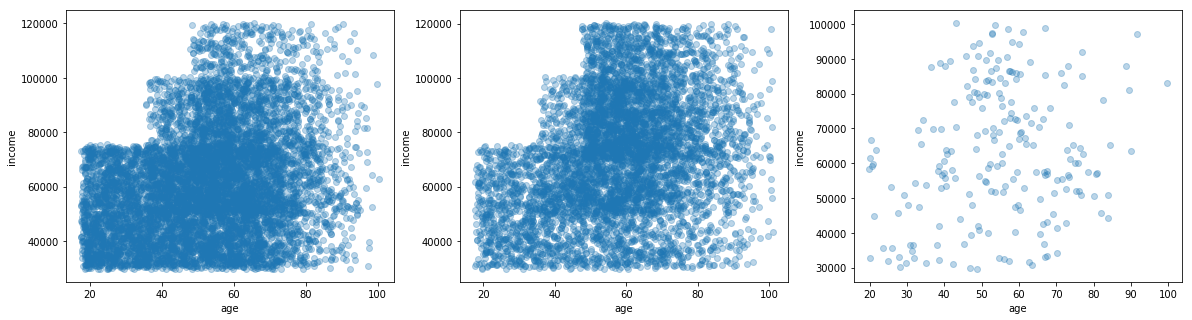

In [235]:
plt.figure(figsize=[20,5])
plt.subplot(1,3,1)
male_profile = profile2[profile2.gender_M == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.3}, fit_reg=False);


plt.subplot(1,3,2)
male_profile = profile2[profile2.gender_F == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.3}, fit_reg=False);


plt.subplot(1,3,3)
male_profile = profile2[profile2.gender_O == 1]
bins_x = np.arange(15,100,3)
bins_y = np.arange(30000,180000, 5000)
sns.regplot(x=male_profile.age, y=male_profile.income,x_jitter=0.5, y_jitter=500, scatter_kws={"alpha":0.3}, fit_reg=False);

## (2) transcript

In [89]:
transcript2.tail(500)

,event,person,time,reward,id
306034,transaction,190fcd45fd074de8b41531fc6ffa6f42,714,4.46,NaN
306035,transaction,d0a70db109564df1be5f0cfcf3296642,714,2.93,NaN
306036,transaction,7c04f1c0d5764d878c4301062c245ecd,714,21.08,NaN
306037,transaction,8d0222afd15e4107b591494ea69714f7,714,7.48,NaN
306038,transaction,5e911bd98a2c4d5d80e2b583a9ad3095,714,1.19,NaN
306039,offer viewed,274d1c34654b44e18c63042367453f60,714,NaN,2906b810c7d4411798c6938adc9daaa5
306040,transaction,bfe8855ff5f34cf6a8e7ce556b0e7e73,714,13.56,NaN
306041,transaction,19b675ce8cea454d8b849fbff3c0ff75,714,20.26,NaN
306042,transaction,73d249175a594096b82528817cb483db,714,19.69,NaN
306043,offer completed,73d249175a594096b82528817cb483db,714,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [86]:
transcript2.sort_values(by=["person","time"])[:10]

,event,person,time,reward,id
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d
168412,transaction,0009655768c64bdeb2e877511632db8f,414,8.57,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,fafdcd668e3743c1bb461111dcafc2a4


In [119]:
transcript2.describe()

,time,reward
count,306534.000000,138953.000000
mean,366.382940,12.777356
std,200.326314,30.250529
min,0.000000,0.050000
25%,186.000000,2.780000
50%,408.000000,8.890000
75%,528.000000,18.070000
max,714.000000,1062.280000


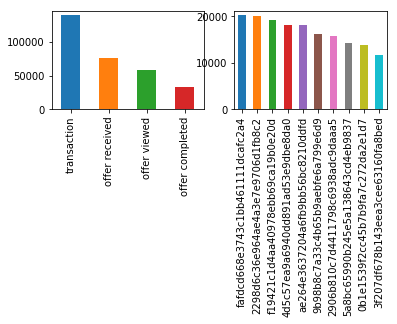

In [82]:
# Distribution of kind of events
plt.subplot(2,2,1)
transcript2.event.value_counts().plot("bar")
# Distribution of offers 
plt.subplot(2,2,2)
transcript2.merge(portfolio, on="id").id.value_counts().plot("bar")

<Figure size 432x288 with 0 Axes>

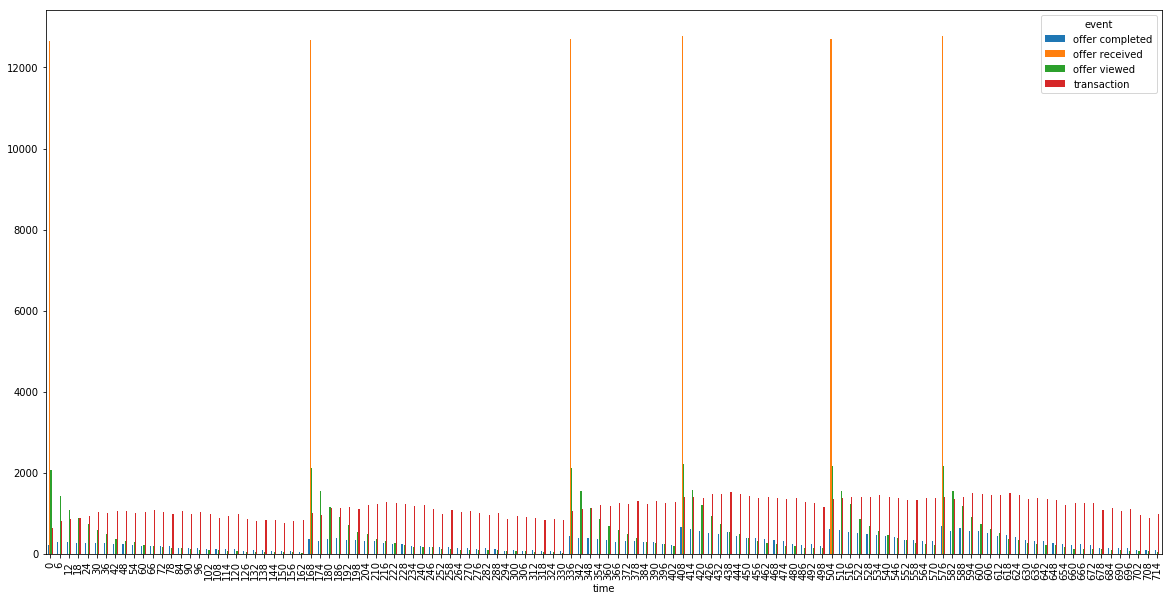

In [212]:
plt.rcParams["font.size"] = 10
plt.tight_layout()
transcript2.groupby(by = "event").time.value_counts().unstack(0).plot.bar(figsize=(20,10))

In [217]:
transcript2[transcript2.event == "offer received"].time.value_counts().sort_index()

0      12650
168    12669
336    12711
408    12778
504    12704
576    12765
Name: time, dtype: int64

Offers are issued on **day 0, 7, 14, 17, 21, 24**.

* Offers which are valid for 10 days since day21
* Offers which are valid for 7,10 days since day24

expires after the end of observation period.
 
It should be better to remove these offer result, but if there is a bias in these offers(i.e. Offers for young women are issued on day 24 mainly), it means that the sample size for a specific demographics for a specific type of offer would be significantly small. To check this, I have to take a look at the attributes of customers who are 

* Offered 

In [229]:
transcript2[transcript2.event == "offer received"].groupby(["time","id"]).event.count()

time  id                              
0     0b1e1539f2cc45b7b9fa7c272da2e1d7    1297
      2298d6c36e964ae4a3e7e9706d1fb8c2    1221
      2906b810c7d4411798c6938adc9daaa5    1257
      3f207df678b143eea3cee63160fa8bed    1273
      4d5c57ea9a6940dd891ad53e9dbe8da0    1218
      5a8bc65990b245e5a138643cd4eb9837    1266
      9b98b8c7a33c4b65b9aebfe6a799e6d9    1245
      ae264e3637204a6fb9bb56bc8210ddfd    1292
      f19421c1d4aa40978ebb69ca19b0e20d    1263
      fafdcd668e3743c1bb461111dcafc2a4    1318
168   0b1e1539f2cc45b7b9fa7c272da2e1d7    1245
      2298d6c36e964ae4a3e7e9706d1fb8c2    1250
      2906b810c7d4411798c6938adc9daaa5    1270
      3f207df678b143eea3cee63160fa8bed    1266
      4d5c57ea9a6940dd891ad53e9dbe8da0    1240
      5a8bc65990b245e5a138643cd4eb9837    1270
      9b98b8c7a33c4b65b9aebfe6a799e6d9    1296
      ae264e3637204a6fb9bb56bc8210ddfd    1319
      f19421c1d4aa40978ebb69ca19b0e20d    1263
      fafdcd668e3743c1bb461111dcafc2a4    1250
336   0b1e1539f2cc45b

In [224]:
c = transcript2[(transcript2.id == "0b1e1539f2cc45b7b9fa7c272da2e1d7") | (transcript2.id == "fafdcd668e3743c1bb461111dcafc2a4")]
c[c.time == 576].shape

(3109, 5)

In [127]:
transcript2.time.unique()

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222, 228,
       234, 240, 246, 252, 258, 264, 270, 276, 282, 288, 294, 300, 306,
       312, 318, 324, 330, 336, 342, 348, 354, 360, 366, 372, 378, 384,
       390, 396, 402, 408, 414, 420, 426, 432, 438, 444, 450, 456, 462,
       468, 474, 480, 486, 492, 498, 504, 510, 516, 522, 528, 534, 540,
       546, 552, 558, 564, 570, 576, 582, 588, 594, 600, 606, 612, 618,
       624, 630, 636, 642, 648, 654, 660, 666, 672, 678, 684, 690, 696,
       702, 708, 714])

# 3. 1st Analysis (on identifying target segments who tend to VIEW offers more)

**I assume that whether a customer views an offer depends on the segment which the one belong to and the duration that offer is valid.**   
(because if that offer is valid for 7 days, it is more likely to be viewed than 10 day-valid offer)

## 3.1. Firstly, I visualize 3 attributes of customers in "profile" with 3D graph.

Firstly, I apply feature scaling

In [3]:
#

# Data Cleaning

"portfolio" and "transcript" should be combined together.

### (1) clean "transcript" by replacing "offer id" to "offer_id"

In [4]:
transcript2 = transcript.copy()

NameError: name 'transcript' is not defined

In [5]:
transcript2 = transcript2.sort_values(by=["person","time"])

# one hot encode "event" with 4 columns "offer received","offer viewed","offer completed","transaction"
transcript2 = transcript2.join(pd.get_dummies(transcript2.event)[["offer received","offer viewed","offer completed","transaction"]])

NameError: name 'transcript2' is not defined

In [6]:
list_values = []

for each_value in transcript2.value:
    list_values.append(list(dict(each_value).values())[0])

NameError: name 'transcript2' is not defined

In [7]:
transcript2["id"] = list_values
transcript2 = transcript2.drop("value",axis=1)

NameError: name 'transcript2' is not defined

In [8]:
transcript2 = transcript2.merge(right = portfolio, on = "id", how = "left")

NameError: name 'transcript2' is not defined

In [9]:
# convert duration from days to hours
transcript2.duration = transcript2.duration * 24

NameError: name 'transcript2' is not defined

In [10]:
# transcript2

In [187]:
# create a new dataframe whose each row represents each offer

df = pd.DataFrame(columns=["person", "offer_id", "offer_type" "received_time", "viewed_time", "completed_time", "purchase_regardless_offer",     ])



last_person = None

for index,row in transcript2.iterrows():
    # if the row I am looking now is abut the same customer as one in the row above
    if row.person == last_person:
        
        # if the row is the offer
        if row_event == "offer_received":
            n_th_offer = i
            
    # if the row I am looking now is abut the different customer from the row above      
    else:
        # reset the offer count
        n_th_offer = 1
    
    # increment offer count by 1
    n_th_offer+=1
        
        
        
        
        

SyntaxError: invalid syntax (<ipython-input-187-f87685c1484c>, line 16)

In [10]:
for each_col in ["offer received","offer viewed","offer completed","transaction"]:
    transcript2[each_col] *= transcript2.time

In [66]:
[list(each_cell.values())[0] for each_cell in transcript2.value]

AttributeError: 'str' object has no attribute 'values'

In [98]:
transcript2.merge(right = portfolio, left_on = transcript2.value.str["offer_id"], how = "left", right_on = "id")

KeyError: {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}

In [96]:
transcript2

,event,person,time,value,offer received,offer viewed,offer completed,transaction
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},1,0,0,0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,1,0,0
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},0,0,0,1
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},1,0,0,0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0,1,0,0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},1,0,0,0
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},0,0,0,1
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,0,0,1,0
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,1,0,0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},1,0,0,0


In [201]:
transcript.groupby(["person","event"])["value"].count()

person                            event          
0009655768c64bdeb2e877511632db8f  offer completed     3
                                  offer received      5
                                  offer viewed        4
                                  transaction         8
00116118485d4dfda04fdbaba9a87b5c  offer received      2
                                  offer viewed        2
                                  transaction         3
0011e0d4e6b944f998e987f904e8c1e5  offer completed     3
                                  offer received      5
                                  offer viewed        5
                                  transaction         5
0020c2b971eb4e9188eac86d93036a77  offer completed     3
                                  offer received      5
                                  offer viewed        3
                                  transaction         8
0020ccbbb6d84e358d3414a3ff76cffd  offer completed     3
                                  offer received      

In [17]:
portfolio2 = portfolio.copy()

In [18]:
portfolio2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [20]:
portfolio2.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


### profile 

In [11]:
profile2 = profile.copy()

In [12]:
profile2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [13]:
# convert "became_member_on" column to datetime type
profile2.became_member_on = pd.to_datetime(profile2.became_member_on)

In [16]:
# one-hot encode "age" column with "male", "female", "other"
pd.get_dummies(profile2.gender).sum()

F    6129
M    8484
O     212
dtype: int64